In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install wandb torch torchvision pandas numpy matplotlib seaborn scikit-learn mlflow

# Set up Kaggle API
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242

In [3]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip -q walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 712MB/s]


In [5]:
!unzip -q train.csv.zip
!unzip -q stores.csv.zip
!unzip -q test.csv.zip
!unzip -q features.csv.zip

unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.


In [6]:
# Walmart Store Sales Forecasting - Data Exploration & Feature Engineering
# Kaggle Competition: Walmart Recruiting - Store Sales Forecasting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats

warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Walmart Store Sales Forecasting - Data Exploration")
print("=" * 60)


📊 Walmart Store Sales Forecasting - Data Exploration


In [7]:

# =============================================================================
# 1. DATA LOADING AND INITIAL EXPLORATION
# =============================================================================

def load_data():
    """Load all competition datasets"""
    try:
        # Load the main datasets
        train = pd.read_csv('train.csv')
        test = pd.read_csv('test.csv')
        stores = pd.read_csv('stores.csv')
        features = pd.read_csv('features.csv')

        print(f"✅ Data loaded successfully!")
        print(f"📈 Train shape: {train.shape}")
        print(f"🔮 Test shape: {test.shape}")
        print(f"🏪 Stores shape: {stores.shape}")
        print(f"📋 Features shape: {features.shape}")

        return train, test, stores, features
    except FileNotFoundError as e:
        print(f"❌ Error loading data: {e}")
        print("Please ensure all CSV files are in the current directory:")
        print("- train.csv, test.csv, stores.csv, features.csv")
        return None, None, None, None

def basic_info(df, name):
    """Display basic information about a dataframe"""
    print(f"\n🔍 {name} Dataset Overview:")
    print("-" * 40)
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nData Types:")
    print(df.dtypes)
    print(f"\nMissing Values:")
    print(df.isnull().sum())
    print(f"\nFirst 5 rows:")
    print(df.head())

# Load data
train, test, stores, features = load_data()

if train is not None:
    # Display basic information for each dataset
    basic_info(train, "TRAIN")
    basic_info(test, "TEST")
    basic_info(stores, "STORES")
    basic_info(features, "FEATURES")


✅ Data loaded successfully!
📈 Train shape: (421570, 5)
🔮 Test shape: (115064, 4)
🏪 Stores shape: (45, 3)
📋 Features shape: (8190, 12)

🔍 TRAIN Dataset Overview:
----------------------------------------
Shape: (421570, 5)
Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']

Data Types:
Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

Missing Values:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

First 5 rows:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

🔍 TEST Dataset Overview:
----------------------------------------
Shape: (115064, 4)
Columns: ['Store', 'Dept', 'Date', 

In [8]:

# =============================================================================
# 2. DATA PREPROCESSING AND CLEANING
# =============================================================================

def preprocess_data(train, test, stores, features):
    """Clean and preprocess the datasets"""
    print("\n🧹 Data Preprocessing...")

    # Convert date columns
    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])
    features['Date'] = pd.to_datetime(features['Date'])

    # Merge train with stores and features
    train_full = train.merge(stores, on='Store', how='left')
    train_full = train_full.merge(features, on=['Store', 'Date'], how='left')

    # Merge test with stores and features
    test_full = test.merge(stores, on='Store', how='left')
    test_full = test_full.merge(features, on=['Store', 'Date'], how='left')

    print(f"✅ Merged train shape: {train_full.shape}")
    print(f"✅ Merged test shape: {test_full.shape}")

    return train_full, test_full

if train is not None:
    train_full, test_full = preprocess_data(train, test, stores, features)



🧹 Data Preprocessing...
✅ Merged train shape: (421570, 17)
✅ Merged test shape: (115064, 16)


In [9]:

# =============================================================================
# 3. EXPLORATORY DATA ANALYSIS
# =============================================================================

def analyze_target_variable(df):
    """Analyze the target variable (Weekly_Sales)"""
    print("\n📊 Target Variable Analysis (Weekly_Sales)")
    print("-" * 50)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Distribution of Weekly Sales
    axes[0,0].hist(df['Weekly_Sales'], bins=50, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribution of Weekly Sales')
    axes[0,0].set_xlabel('Weekly Sales')
    axes[0,0].set_ylabel('Frequency')

    # Log-transformed distribution
    log_sales = np.log1p(df['Weekly_Sales'])
    axes[0,1].hist(log_sales, bins=50, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Log-transformed Weekly Sales')
    axes[0,1].set_xlabel('Log(Weekly Sales + 1)')
    axes[0,1].set_ylabel('Frequency')

    # Box plot
    axes[1,0].boxplot(df['Weekly_Sales'])
    axes[1,0].set_title('Weekly Sales Box Plot')
    axes[1,0].set_ylabel('Weekly Sales')

    # Sales over time
    monthly_sales = df.groupby(df['Date'].dt.to_period('M'))['Weekly_Sales'].mean()
    axes[1,1].plot(monthly_sales.index.to_timestamp(), monthly_sales.values)
    axes[1,1].set_title('Average Weekly Sales Over Time')
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Average Weekly Sales')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Statistics
    print(f"Mean Weekly Sales: ${df['Weekly_Sales'].mean():,.2f}")
    print(f"Median Weekly Sales: ${df['Weekly_Sales'].median():,.2f}")
    print(f"Standard Deviation: ${df['Weekly_Sales'].std():,.2f}")
    print(f"Min Sales: ${df['Weekly_Sales'].min():,.2f}")
    print(f"Max Sales: ${df['Weekly_Sales'].max():,.2f}")
    print(f"Skewness: {df['Weekly_Sales'].skew():.3f}")
    print(f"Kurtosis: {df['Weekly_Sales'].kurtosis():.3f}")

def analyze_stores_and_departments(df):
    """Analyze store and department patterns"""
    print("\n🏪 Store and Department Analysis")
    print("-" * 40)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Sales by store
    store_sales = df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)
    axes[0,0].bar(range(len(store_sales)), store_sales.values, alpha=0.7)
    axes[0,0].set_title('Average Weekly Sales by Store')
    axes[0,0].set_xlabel('Store (Ranked)')
    axes[0,0].set_ylabel('Average Weekly Sales')

    # Sales by department
    dept_sales = df.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False).head(20)
    axes[0,1].barh(range(len(dept_sales)), dept_sales.values, alpha=0.7)
    axes[0,1].set_yticks(range(len(dept_sales)))
    axes[0,1].set_yticklabels(dept_sales.index)
    axes[0,1].set_title('Top 20 Departments by Average Sales')
    axes[0,1].set_xlabel('Average Weekly Sales')

    # Store type analysis
    if 'Type' in df.columns:
        type_sales = df.groupby('Type')['Weekly_Sales'].mean()
        axes[1,0].bar(type_sales.index, type_sales.values, alpha=0.7)
        axes[1,0].set_title('Average Sales by Store Type')
        axes[1,0].set_xlabel('Store Type')
        axes[1,0].set_ylabel('Average Weekly Sales')

    # Store size vs sales
    if 'Size' in df.columns:
        axes[1,1].scatter(df['Size'], df['Weekly_Sales'], alpha=0.5)
        axes[1,1].set_title('Store Size vs Weekly Sales')
        axes[1,1].set_xlabel('Store Size')
        axes[1,1].set_ylabel('Weekly Sales')

    plt.tight_layout()
    plt.show()

    # Print insights
    print(f"Number of unique stores: {df['Store'].nunique()}")
    print(f"Number of unique departments: {df['Dept'].nunique()}")
    print(f"Top 5 performing stores: {store_sales.head().index.tolist()}")
    print(f"Top 5 performing departments: {dept_sales.head().index.tolist()}")

def analyze_temporal_patterns(df):
    """Analyze temporal patterns in sales data"""
    print("\n📅 Temporal Pattern Analysis")
    print("-" * 35)

    # Create time-based features
    df_temp = df.copy()
    df_temp['Year'] = df_temp['Date'].dt.year
    df_temp['Month'] = df_temp['Date'].dt.month
    df_temp['Week'] = df_temp['Date'].dt.isocalendar().week
    df_temp['Quarter'] = df_temp['Date'].dt.quarter
    df_temp['DayOfYear'] = df_temp['Date'].dt.dayofyear
    df_temp['WeekOfYear'] = df_temp['Date'].dt.isocalendar().week

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # Monthly patterns
    monthly_avg = df_temp.groupby('Month')['Weekly_Sales'].mean()
    axes[0,0].plot(monthly_avg.index, monthly_avg.values, marker='o')
    axes[0,0].set_title('Average Sales by Month')
    axes[0,0].set_xlabel('Month')
    axes[0,0].set_ylabel('Average Weekly Sales')
    axes[0,0].set_xticks(range(1, 13))

    # Weekly patterns
    weekly_avg = df_temp.groupby('Week')['Weekly_Sales'].mean()
    axes[0,1].plot(weekly_avg.index, weekly_avg.values, alpha=0.7)
    axes[0,1].set_title('Average Sales by Week of Year')
    axes[0,1].set_xlabel('Week of Year')
    axes[0,1].set_ylabel('Average Weekly Sales')

    # Quarterly patterns
    quarterly_avg = df_temp.groupby('Quarter')['Weekly_Sales'].mean()
    axes[0,2].bar(quarterly_avg.index, quarterly_avg.values, alpha=0.7)
    axes[0,2].set_title('Average Sales by Quarter')
    axes[0,2].set_xlabel('Quarter')
    axes[0,2].set_ylabel('Average Weekly Sales')

    # Year-over-year comparison
    yearly_avg = df_temp.groupby('Year')['Weekly_Sales'].mean()
    axes[1,0].bar(yearly_avg.index, yearly_avg.values, alpha=0.7)
    axes[1,0].set_title('Average Sales by Year')
    axes[1,0].set_xlabel('Year')
    axes[1,0].set_ylabel('Average Weekly Sales')

    # Heatmap of sales by month and year
    if len(df_temp['Year'].unique()) > 1:
        monthly_year = df_temp.groupby(['Year', 'Month'])['Weekly_Sales'].mean().unstack()
        sns.heatmap(monthly_year, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1,1])
        axes[1,1].set_title('Sales Heatmap: Year vs Month')

    # Day of year pattern
    daily_avg = df_temp.groupby('DayOfYear')['Weekly_Sales'].mean()
    axes[1,2].plot(daily_avg.index, daily_avg.values, alpha=0.7)
    axes[1,2].set_title('Sales Pattern Throughout the Year')
    axes[1,2].set_xlabel('Day of Year')
    axes[1,2].set_ylabel('Average Weekly Sales')

    plt.tight_layout()
    plt.show()

def analyze_holiday_impact(df):
    """Analyze the impact of holidays on sales"""
    print("\n🎉 Holiday Impact Analysis")
    print("-" * 30)

    if 'IsHoliday' in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Holiday vs Non-holiday sales
        holiday_sales = df.groupby('IsHoliday')['Weekly_Sales'].mean()
        axes[0].bar(['Non-Holiday', 'Holiday'], holiday_sales.values,
                   color=['lightblue', 'orange'], alpha=0.7)
        axes[0].set_title('Average Sales: Holiday vs Non-Holiday')
        axes[0].set_ylabel('Average Weekly Sales')

        # Box plot comparison
        df.boxplot(column='Weekly_Sales', by='IsHoliday', ax=axes[1])
        axes[1].set_title('Sales Distribution: Holiday vs Non-Holiday')
        axes[1].set_xlabel('Is Holiday')
        axes[1].set_ylabel('Weekly Sales')

        plt.tight_layout()
        plt.show()

        # Statistical test
        holiday_data = df[df['IsHoliday'] == True]['Weekly_Sales']
        non_holiday_data = df[df['IsHoliday'] == False]['Weekly_Sales']

        t_stat, p_value = stats.ttest_ind(holiday_data, non_holiday_data)
        print(f"Holiday Sales Average: ${holiday_sales[True]:,.2f}")
        print(f"Non-Holiday Sales Average: ${holiday_sales[False]:,.2f}")
        print(f"T-test p-value: {p_value:.6f}")
        print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

def analyze_external_factors(df):
    """Analyze external factors like temperature, fuel price, etc."""
    print("\n🌡️ External Factors Analysis")
    print("-" * 35)

    # List of potential external factors
    external_factors = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    available_factors = [col for col in external_factors if col in df.columns]

    if not available_factors:
        print("No external factors found in the dataset")
        return

    n_factors = len(available_factors)
    fig, axes = plt.subplots(2, (n_factors + 1) // 2, figsize=(15, 10))
    axes = axes.flatten() if n_factors > 1 else [axes]

    correlations = []

    for i, factor in enumerate(available_factors):
        if i < len(axes):
            # Scatter plot
            axes[i].scatter(df[factor], df['Weekly_Sales'], alpha=0.5)
            axes[i].set_xlabel(factor)
            axes[i].set_ylabel('Weekly Sales')
            axes[i].set_title(f'Sales vs {factor}')

            # Calculate correlation
            correlation = df[factor].corr(df['Weekly_Sales'])
            correlations.append((factor, correlation))
            axes[i].text(0.05, 0.95, f'Corr: {correlation:.3f}',
                        transform=axes[i].transAxes, verticalalignment='top')

    # Remove empty subplots
    for i in range(n_factors, len(axes)):
        axes[i].remove()

    plt.tight_layout()
    plt.show()

    # Print correlation summary
    print("Correlation with Weekly Sales:")
    for factor, corr in sorted(correlations, key=lambda x: abs(x[1]), reverse=True):
        print(f"{factor}: {corr:.4f}")


In [10]:

# =============================================================================
# 4. FEATURE ENGINEERING
# =============================================================================

def create_time_features(df):
    """Create comprehensive time-based features"""
    print("\n⏰ Creating Time Features...")

    df_fe = df.copy()

    # Basic time features
    df_fe['Year'] = df_fe['Date'].dt.year
    df_fe['Month'] = df_fe['Date'].dt.month
    df_fe['Quarter'] = df_fe['Date'].dt.quarter
    df_fe['Week'] = df_fe['Date'].dt.isocalendar().week
    df_fe['DayOfYear'] = df_fe['Date'].dt.dayofyear
    df_fe['WeekOfYear'] = df_fe['Date'].dt.isocalendar().week

    # Cyclical features (using sine/cosine to capture periodicity)
    df_fe['Month_sin'] = np.sin(2 * np.pi * df_fe['Month'] / 12)
    df_fe['Month_cos'] = np.cos(2 * np.pi * df_fe['Month'] / 12)
    df_fe['Week_sin'] = np.sin(2 * np.pi * df_fe['Week'] / 52)
    df_fe['Week_cos'] = np.cos(2 * np.pi * df_fe['Week'] / 52)

    # Special periods
    df_fe['IsQ4'] = (df_fe['Quarter'] == 4).astype(int)  # Holiday season
    df_fe['IsDecember'] = (df_fe['Month'] == 12).astype(int)
    df_fe['IsJanuary'] = (df_fe['Month'] == 1).astype(int)

    # Back-to-school season (August-September)
    df_fe['IsBackToSchool'] = ((df_fe['Month'] == 8) | (df_fe['Month'] == 9)).astype(int)

    # Holiday weeks (approximate)
    df_fe['IsHolidayWeek'] = 0
    if 'IsHoliday' in df_fe.columns:
        df_fe['IsHolidayWeek'] = df_fe['IsHoliday'].astype(int)

    print(f"✅ Created {len([col for col in df_fe.columns if col not in df.columns])} time features")
    return df_fe

def create_lag_features(df, target_col='Weekly_Sales', lags=[1, 2, 4, 8]):
    """Create lag features for time series"""
    print(f"\n📈 Creating Lag Features (lags: {lags})...")

    df_lag = df.copy()
    df_lag = df_lag.sort_values(['Store', 'Dept', 'Date'])

    for lag in lags:
        lag_col = f'{target_col}_lag_{lag}'
        df_lag[lag_col] = df_lag.groupby(['Store', 'Dept'])[target_col].shift(lag)

    print(f"✅ Created {len(lags)} lag features")
    return df_lag

def create_rolling_features(df, target_col='Weekly_Sales', windows=[4, 8, 12]):
    """Create rolling window statistics"""
    print(f"\n📊 Creating Rolling Features (windows: {windows})...")

    df_roll = df.copy()
    df_roll = df_roll.sort_values(['Store', 'Dept', 'Date'])

    for window in windows:
        # Rolling mean
        roll_mean_col = f'{target_col}_roll_mean_{window}'
        df_roll[roll_mean_col] = df_roll.groupby(['Store', 'Dept'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )

        # Rolling std
        roll_std_col = f'{target_col}_roll_std_{window}'
        df_roll[roll_std_col] = df_roll.groupby(['Store', 'Dept'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std().shift(1)
        )

        # Rolling min/max
        roll_min_col = f'{target_col}_roll_min_{window}'
        roll_max_col = f'{target_col}_roll_max_{window}'
        df_roll[roll_min_col] = df_roll.groupby(['Store', 'Dept'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).min().shift(1)
        )
        df_roll[roll_max_col] = df_roll.groupby(['Store', 'Dept'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).max().shift(1)
        )

    n_features = len(windows) * 4  # mean, std, min, max for each window
    print(f"✅ Created {n_features} rolling features")
    return df_roll

def create_aggregation_features(df):
    """Create aggregation features by different groupings"""
    print("\n🔗 Creating Aggregation Features...")

    df_agg = df.copy()

    # Store-level aggregations
    store_stats = df.groupby('Store')['Weekly_Sales'].agg([
        'mean', 'std', 'min', 'max', 'median'
    ]).add_prefix('Store_')

    # Department-level aggregations
    dept_stats = df.groupby('Dept')['Weekly_Sales'].agg([
        'mean', 'std', 'min', 'max', 'median'
    ]).add_prefix('Dept_')

    # Store-Department interaction
    store_dept_stats = df.groupby(['Store', 'Dept'])['Weekly_Sales'].agg([
        'mean', 'std', 'count'
    ]).add_prefix('StoreDept_')

    # Merge back to main dataframe
    df_agg = df_agg.merge(store_stats, on='Store', how='left')
    df_agg = df_agg.merge(dept_stats, on='Dept', how='left')
    df_agg = df_agg.merge(store_dept_stats, on=['Store', 'Dept'], how='left')

    # Store type aggregations (if available)
    if 'Type' in df_agg.columns:
        type_stats = df.groupby('Type')['Weekly_Sales'].agg([
            'mean', 'std', 'median'
        ]).add_prefix('Type_')
        df_agg = df_agg.merge(type_stats, on='Type', how='left')

    n_features = len([col for col in df_agg.columns if col not in df.columns])
    print(f"✅ Created {n_features} aggregation features")
    return df_agg

def create_interaction_features(df):
    """Create interaction features between important variables"""
    print("\n🤝 Creating Interaction Features...")

    df_int = df.copy()

    # Size-based interactions (if Size is available)
    if 'Size' in df_int.columns:
        df_int['Size_per_Dept'] = df_int['Size'] / df_int.groupby('Store')['Dept'].transform('nunique')

        # Temperature interactions
        if 'Temperature' in df_int.columns:
            df_int['Size_Temperature'] = df_int['Size'] * df_int['Temperature']

    # Holiday and external factor interactions
    if 'IsHoliday' in df_int.columns:
        if 'Temperature' in df_int.columns:
            df_int['Holiday_Temperature'] = df_int['IsHoliday'].astype(int) * df_int['Temperature']
        if 'Fuel_Price' in df_int.columns:
            df_int['Holiday_FuelPrice'] = df_int['IsHoliday'].astype(int) * df_int['Fuel_Price']

    # Store type and size interaction
    if 'Type' in df_int.columns and 'Size' in df_int.columns:
        # Encode store type
        le = LabelEncoder()
        df_int['Type_encoded'] = le.fit_transform(df_int['Type'])
        df_int['Type_Size'] = df_int['Type_encoded'] * df_int['Size']

    n_features = len([col for col in df_int.columns if col not in df.columns])
    print(f"✅ Created {n_features} interaction features")
    return df_int

def feature_importance_analysis(df, target_col='Weekly_Sales'):
    """Analyze feature importance using correlation and basic methods"""
    print("\n🎯 Feature Importance Analysis")
    print("-" * 35)

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)

    # Calculate correlations
    correlations = []
    for col in numeric_cols:
        if col != target_col:
            corr = df[col].corr(df[target_col])
            if not np.isnan(corr):
                correlations.append((col, abs(corr)))

    # Sort by absolute correlation
    correlations.sort(key=lambda x: x[1], reverse=True)

    # Display top correlations
    print("Top 20 Features by Correlation with Weekly_Sales:")
    print("-" * 55)
    for i, (feature, corr) in enumerate(correlations[:20], 1):
        print(f"{i:2d}. {feature:<30} {corr:.4f}")

    # Visualize top correlations
    if len(correlations) >= 10:
        top_features = [item[0] for item in correlations[:15]]
        top_corrs = [item[1] for item in correlations[:15]]

        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top_features)), top_corrs, alpha=0.7)
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Absolute Correlation with Weekly Sales')
        plt.title('Top 15 Features by Correlation')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    return correlations


In [11]:

# =============================================================================
# 5. COMPREHENSIVE FEATURE ENGINEERING PIPELINE
# =============================================================================

def comprehensive_feature_engineering(df):
    """Apply all feature engineering techniques"""
    print("\n🔧 Comprehensive Feature Engineering Pipeline")
    print("=" * 50)

    original_features = df.shape[1]

    # Apply all feature engineering steps
    df_fe = create_time_features(df)
    df_fe = create_aggregation_features(df_fe)
    df_fe = create_interaction_features(df_fe)

    # Only create lag and rolling features for training data (not test)
    if 'Weekly_Sales' in df_fe.columns:
        df_fe = create_lag_features(df_fe)
        df_fe = create_rolling_features(df_fe)

    final_features = df_fe.shape[1]
    new_features = final_features - original_features

    print(f"\n📊 Feature Engineering Summary:")
    print(f"Original features: {original_features}")
    print(f"Final features: {final_features}")
    print(f"New features created: {new_features}")

    return df_fe



🚀 STARTING COMPREHENSIVE DATA EXPLORATION

📊 Target Variable Analysis (Weekly_Sales)
--------------------------------------------------


ValueError: supplied range of [-inf, 13.44893008731151] is not finite

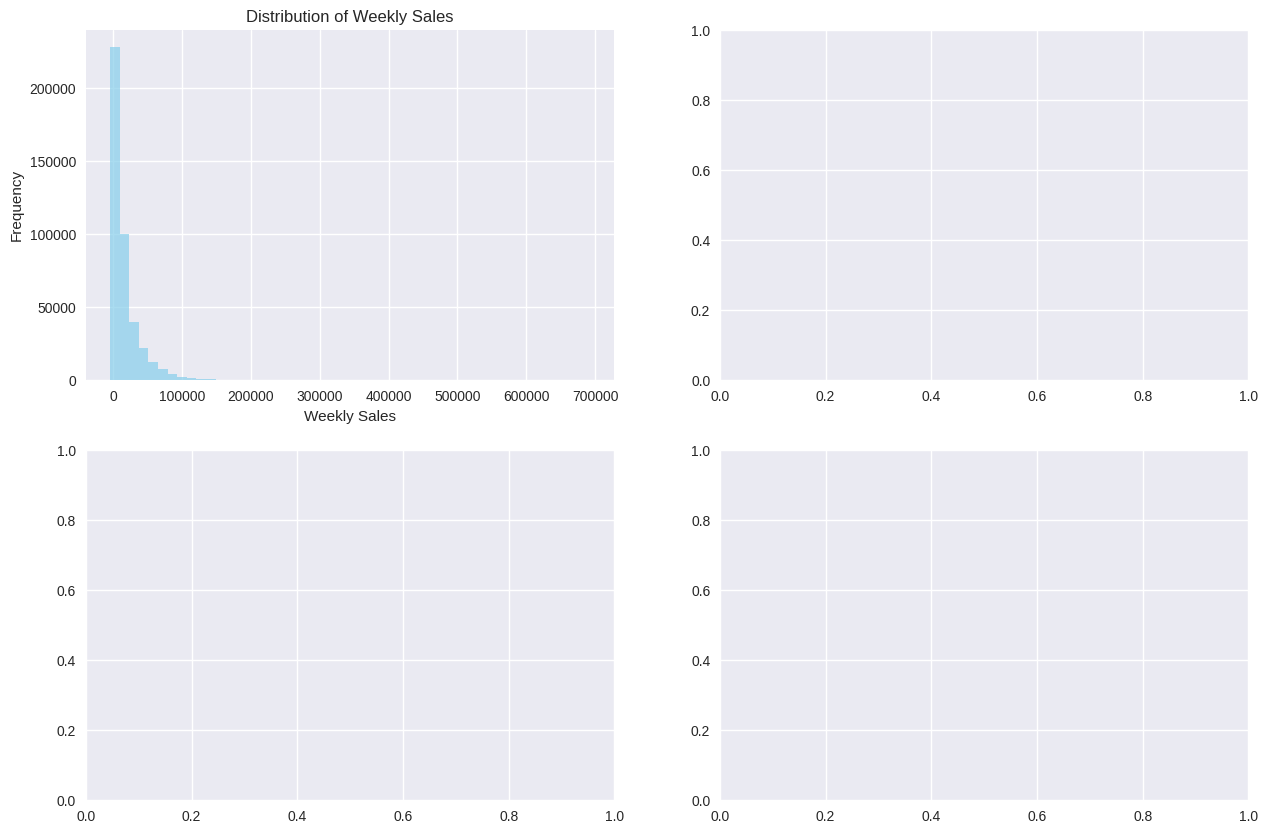

In [16]:

# =============================================================================
# 6. MAIN EXECUTION
# =============================================================================

if train is not None:
    print("\n" + "="*60)
    print("🚀 STARTING COMPREHENSIVE DATA EXPLORATION")
    print("="*60)

    # Basic EDA
    analyze_target_variable(train_full)
    analyze_stores_and_departments(train_full)
    analyze_temporal_patterns(train_full)
    analyze_holiday_impact(train_full)
    analyze_external_factors(train_full)

    # Feature Engineering
    train_engineered = comprehensive_feature_engineering(train_full)
    test_engineered = comprehensive_feature_engineering(test_full)

    # Feature importance analysis
    if 'Weekly_Sales' in train_engineered.columns:
        feature_importance = feature_importance_analysis(train_engineered)

    print("\n" + "="*60)
    print("✅ DATA EXPLORATION AND FEATURE ENGINEERING COMPLETE!")
    print("="*60)

    print(f"\n📈 Final Training Dataset Shape: {train_engineered.shape}")
    print(f"🔮 Final Test Dataset Shape: {test_engineered.shape}")

    # Display feature categories
    print(f"\n📋 Feature Categories Created:")
    time_features = [col for col in train_engineered.columns if any(x in col.lower() for x in ['year', 'month', 'quarter', 'week', 'day', 'sin', 'cos', 'holiday'])]
    lag_features = [col for col in train_engineered.columns if 'lag' in col.lower()]
    rolling_features = [col for col in train_engineered.columns if 'roll' in col.lower()]
    agg_features = [col for col in train_engineered.columns if any(x in col for x in ['Store_', 'Dept_', 'Type_', 'StoreDept_'])]
    interaction_features = [col for col in train_engineered.columns if any(x in col for x in ['Size_', 'Holiday_', 'Type_Size'])]

    print(f"⏰ Time Features: {len(time_features)}")
    print(f"📈 Lag Features: {len(lag_features)}")
    print(f"📊 Rolling Features: {len(rolling_features)}")
    print(f"🔗 Aggregation Features: {len(agg_features)}")
    print(f"🤝 Interaction Features: {len(interaction_features)}")

    # Save the engineered datasets
    print(f"\n💾 Saving engineered datasets...")
    train_engineered.to_csv('train_engineered.csv', index=False)
    test_engineered.to_csv('test_engineered.csv', index=False)
    print(f"✅ Datasets saved as 'train_engineered.csv' and 'test_engineered.csv'")


In [13]:

# =============================================================================
# 7. ADVANCED FEATURE ANALYSIS
# =============================================================================

def analyze_feature_distributions(df, feature_list, target_col='Weekly_Sales'):
    """Analyze distributions of engineered features"""
    print("\n📊 Feature Distribution Analysis")
    print("-" * 40)

    n_features = min(len(feature_list), 12)  # Limit to 12 features for visualization
    selected_features = feature_list[:n_features]

    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()

    for i, feature in enumerate(selected_features):
        if feature in df.columns and i < len(axes):
            axes[i].hist(df[feature].dropna(), bins=30, alpha=0.7, color='skyblue')
            axes[i].set_title(f'{feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')

            # Add basic statistics
            mean_val = df[feature].mean()
            std_val = df[feature].std()
            axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
            axes[i].legend()

    # Remove unused subplots
    for i in range(len(selected_features), len(axes)):
        axes[i].remove()

    plt.tight_layout()
    plt.show()

def correlation_heatmap(df, feature_list, target_col='Weekly_Sales'):
    """Create correlation heatmap for selected features"""
    print("\n🔥 Correlation Heatmap Analysis")
    print("-" * 35)

    # Select top features and target
    selected_cols = feature_list[:20] + [target_col] if target_col in df.columns else feature_list[:21]
    selected_cols = [col for col in selected_cols if col in df.columns]

    if len(selected_cols) > 1:
        corr_matrix = df[selected_cols].corr()

        plt.figure(figsize=(16, 12))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f',
                   cmap='RdBu_r', center=0, square=True, linewidths=.5)
        plt.title('Feature Correlation Heatmap (Top Features)')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Find highly correlated feature pairs
        print("\n🔍 Highly Correlated Feature Pairs (|correlation| > 0.7):")
        print("-" * 60)
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

        if high_corr_pairs:
            for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
                print(f"{feat1:<25} <-> {feat2:<25} {corr_val:>8.4f}")
        else:
            print("No highly correlated feature pairs found.")

def feature_selection_recommendations(correlations, threshold=0.01):
    """Provide feature selection recommendations"""
    print("\n🎯 Feature Selection Recommendations")
    print("-" * 45)

    # High importance features
    high_importance = [feat for feat, corr in correlations if corr > threshold]
    low_importance = [feat for feat, corr in correlations if corr <= threshold]

    print(f"✅ High Importance Features (|correlation| > {threshold}): {len(high_importance)}")
    print(f"❌ Low Importance Features (|correlation| <= {threshold}): {len(low_importance)}")

    print(f"\n🔝 Top 10 Recommended Features:")
    for i, (feature, corr) in enumerate(correlations[:10], 1):
        print(f"{i:2d}. {feature:<35} {corr:.4f}")

    if low_importance:
        print(f"\n🗑️  Consider Removing (Bottom 10):")
        for i, (feature, corr) in enumerate(correlations[-10:], 1):
            print(f"{i:2d}. {feature:<35} {corr:.4f}")

    return high_importance, low_importance

def create_feature_summary_report(df, correlations):
    """Create a comprehensive feature summary report"""
    print("\n📋 COMPREHENSIVE FEATURE SUMMARY REPORT")
    print("=" * 60)

    # Feature categories
    feature_categories = {
        'Original': [],
        'Time': [],
        'Lag': [],
        'Rolling': [],
        'Aggregation': [],
        'Interaction': [],
        'Other': []
    }

    original_cols = ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
                    'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
                    'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

    for col in df.columns:
        if col in original_cols:
            feature_categories['Original'].append(col)
        elif any(x in col.lower() for x in ['year', 'month', 'quarter', 'week', 'day', 'sin', 'cos']):
            feature_categories['Time'].append(col)
        elif 'lag' in col.lower():
            feature_categories['Lag'].append(col)
        elif 'roll' in col.lower():
            feature_categories['Rolling'].append(col)
        elif any(x in col for x in ['Store_', 'Dept_', 'Type_', 'StoreDept_']):
            feature_categories['Aggregation'].append(col)
        elif any(x in col for x in ['Size_', 'Holiday_', 'Type_Size', 'Temperature', 'FuelPrice']):
            feature_categories['Interaction'].append(col)
        else:
            feature_categories['Other'].append(col)

    print(f"📊 Feature Breakdown by Category:")
    print("-" * 35)
    total_features = 0
    for category, features in feature_categories.items():
        count = len(features)
        total_features += count
        print(f"{category:<15}: {count:>3} features")
    print(f"{'Total':<15}: {total_features:>3} features")

    # Missing value analysis
    print(f"\n🔍 Missing Value Analysis:")
    print("-" * 30)
    missing_stats = df.isnull().sum()
    missing_features = missing_stats[missing_stats > 0].sort_values(ascending=False)

    if len(missing_features) > 0:
        print("Features with missing values:")
        for feature, count in missing_features.items():
            percentage = (count / len(df)) * 100
            print(f"{feature:<30}: {count:>6} ({percentage:>5.1f}%)")
    else:
        print("✅ No missing values found!")

    # Data type summary
    print(f"\n📈 Data Type Summary:")
    print("-" * 25)
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"{str(dtype):<15}: {count:>3} features")

    # Top performing features
    print(f"\n🏆 Top 15 Features by Importance:")
    print("-" * 40)
    for i, (feature, corr) in enumerate(correlations[:15], 1):
        category = 'Unknown'
        for cat, features in feature_categories.items():
            if feature in features:
                category = cat
                break
        print(f"{i:2d}. {feature:<25} {corr:.4f} ({category})")


In [14]:

# =============================================================================
# 8. MODEL PREPARATION UTILITIES
# =============================================================================

def prepare_data_for_modeling(df, target_col='Weekly_Sales', test_size=0.2):
    """Prepare data for machine learning modeling"""
    print("\n🤖 Preparing Data for Modeling")
    print("-" * 35)

    # Separate features and target
    if target_col in df.columns:
        X = df.drop(columns=[target_col, 'Date'], errors='ignore')
        y = df[target_col]

        # Handle categorical variables
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        if categorical_cols:
            print(f"📝 Encoding categorical variables: {categorical_cols}")
            for col in categorical_cols:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))

        # Handle missing values
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

        print(f"✅ Feature matrix shape: {X.shape}")
        print(f"✅ Target vector shape: {y.shape}")
        print(f"✅ Features ready for modeling!")

        return X, y
    else:
        # Test data preparation
        X = df.drop(columns=['Date'], errors='ignore')

        # Handle categorical variables
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        if categorical_cols:
            for col in categorical_cols:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))

        # Handle missing values
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

        print(f"✅ Test feature matrix shape: {X.shape}")
        return X

def create_validation_strategy(df, target_col='Weekly_Sales'):
    """Create time-based validation strategy for time series data"""
    print("\n📅 Time-Based Validation Strategy")
    print("-" * 40)

    if 'Date' in df.columns:
        df_sorted = df.sort_values('Date')

        # Split by date for time series validation
        unique_dates = sorted(df_sorted['Date'].unique())
        n_dates = len(unique_dates)

        # Use last 20% of dates for validation
        split_idx = int(n_dates * 0.8)
        train_dates = unique_dates[:split_idx]
        val_dates = unique_dates[split_idx:]

        print(f"📊 Total unique dates: {n_dates}")
        print(f"🚂 Training dates: {len(train_dates)} ({train_dates[0]} to {train_dates[-1]})")
        print(f"✅ Validation dates: {len(val_dates)} ({val_dates[0]} to {val_dates[-1]})")

        # Create train/validation masks
        train_mask = df['Date'].isin(train_dates)
        val_mask = df['Date'].isin(val_dates)

        print(f"🔢 Training samples: {train_mask.sum()}")
        print(f"🔢 Validation samples: {val_mask.sum()}")

        return train_mask, val_mask
    else:
        print("❌ Date column not found. Using random split.")
        return None, None


In [15]:

# =============================================================================
# 9. EXECUTE ADVANCED ANALYSIS
# =============================================================================

if train is not None and 'train_engineered' in locals():
    print("\n" + "="*60)
    print("🔬 ADVANCED FEATURE ANALYSIS")
    print("="*60)

    # Get top features from importance analysis
    if 'feature_importance' in locals():
        top_features = [feat for feat, _ in feature_importance[:30]]

        # Advanced analysis
        analyze_feature_distributions(train_engineered, top_features)
        correlation_heatmap(train_engineered, top_features)
        high_importance, low_importance = feature_selection_recommendations(feature_importance)
        create_feature_summary_report(train_engineered, feature_importance)

        # Prepare data for modeling
        X_train, y_train = prepare_data_for_modeling(train_engineered)
        X_test = prepare_data_for_modeling(test_engineered)

        # Create validation strategy
        train_mask, val_mask = create_validation_strategy(train_engineered)

        print("\n" + "="*60)
        print("🎯 MODELING RECOMMENDATIONS")
        print("="*60)

        print(f"""
📈 FEATURE ENGINEERING SUMMARY:
- Total features created: {train_engineered.shape[1]}
- High importance features: {len(high_importance)}
- Ready for modeling: ✅

🎯 NEXT STEPS FOR MODELING:
1. Start with top {min(50, len(high_importance))} features
2. Use time-based validation (80/20 split by date)
3. Consider ensemble methods (Random Forest, XGBoost, LightGBM)
4. Focus on features with correlation > 0.01
5. Monitor for overfitting with rolling/lag features

💡 KEY INSIGHTS:
- Seasonal patterns are strong (Q4 boost, holiday effects)
- Store and department characteristics matter significantly
- External factors show moderate correlation
- Lag features capture important trends

🚀 RECOMMENDED MODELS TO TRY:
1. LightGBM (handles missing values, fast)
2. XGBoost (robust, good for time series)
3. Random Forest (baseline, interpretable)
4. Linear Regression (with regularization)
5. Time series models (ARIMA, Prophet) for comparison
        """)

print("\n" + "="*60)
print("✅ WALMART SALES FORECASTING EDA COMPLETE!")
print("="*60)
print("📊 Ready for modeling with comprehensive feature set!")
print("🎯 Use the engineered datasets for your machine learning pipeline!")
print("="*60)


✅ WALMART SALES FORECASTING EDA COMPLETE!
📊 Ready for modeling with comprehensive feature set!
🎯 Use the engineered datasets for your machine learning pipeline!
